# Курсовой проект для курса "Python для Data Science":
# "Построение модели для предсказания цен на недвижимость"

Задание:
Используя данные из обучающего датасета (train.csv), построить модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели, предсказать цены для квартир из тестового датасета (test.csv).

Целевая переменная:
Price

Метрика качества:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Требования к решению:
1. R2 > 0.65
2. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}_solution.ipynb, пример SShirkin_solution.ipynb
3. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}_predictions.csv, пример SShirkin_predictions.csv 
Файл должен содержать два поля: Id, Price и в файле должна быть 5001 строка (шапка + 5000 предсказаний).

### Подключение библиотек и скриптов

In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.image as img
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, GridSearchCV

In [2]:
plt.style.use('seaborn-ticks')
#plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = (6, 4)
matplotlib.rcParams.update({'font.size': 14})

In [3]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

### Загрузка данных

#### Описание датасета:

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [4]:
train_df = pd.read_csv('C:/Users/МаРу/Documents/Geekbrains/Library_python_for_DataScience/Coursework/train.csv', index_col = 'Id')
train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [5]:
test_df = pd.read_csv('C:/Users/МаРу/Documents/Geekbrains/Library_python_for_DataScience/Coursework/test.csv', index_col = 'Id')
test_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [6]:
# Оценим размеры датасетов:
train_df.shape, test_df.shape
# В тестовом датасете отсутствует столбец с ценами, которые и необходимо предсказать.

((10000, 19), (5000, 18))

### Получение информации о данных

In [7]:
train_df.info(), train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     10000 non-null  int64  
 1   Rooms          10000 non-null  float64
 2   Square         10000 non-null  float64
 3   LifeSquare     7887 non-null   float64
 4   KitchenSquare  10000 non-null  float64
 5   Floor          10000 non-null  int64  
 6   HouseFloor     10000 non-null  float64
 7   HouseYear      10000 non-null  int64  
 8   Ecology_1      10000 non-null  float64
 9   Ecology_2      10000 non-null  object 
 10  Ecology_3      10000 non-null  object 
 11  Social_1       10000 non-null  int64  
 12  Social_2       10000 non-null  int64  
 13  Social_3       10000 non-null  int64  
 14  Healthcare_1   5202 non-null   float64
 15  Helthcare_2    10000 non-null  int64  
 16  Shops_1        10000 non-null  int64  
 17  Shops_2        10000 non-null  object 
 18  Pri

(None, None)

In [8]:
# Получим основные метрики по числовым данным

train_df.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [9]:
# Статистика категориальных переменных
train_df.describe(include='object')

,Ecology_2,Ecology_3,Shops_2
count,10000,10000,10000
unique,2,2,2
top,B,B,B
freq,9903,9725,9175


In [10]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [11]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [12]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

In [13]:
# В категориальных переменных обоих датасетов заменим значения А и В на 0 и 1, соответственно:
train_df['Ecology_2'] = train_df['Ecology_2'].replace({'A':0, 'B':1})
train_df['Ecology_3'] = train_df['Ecology_3'].replace({'A':0, 'B':1})
train_df['Shops_2'] = train_df['Shops_2'].replace({'A':0, 'B':1})
test_df['Ecology_2'] = test_df['Ecology_2'].replace({'A':0, 'B':1})
test_df['Ecology_3'] = test_df['Ecology_3'].replace({'A':0, 'B':1})
test_df['Shops_2'] = test_df['Shops_2'].replace({'A':0, 'B':1})

In [14]:
# Проверим замену данных
train_df.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
count,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,0.990300,0.972500,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,0.917500,214138.857399
std,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,0.098015,0.163543,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,0.275139,92872.293865
min,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,1.000000,1.000000,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,1.000000,153872.633942
50%,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,1.000000,1.000000,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,1.000000,192269.644879
75%,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,1.000000,1.000000,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,1.000000,249135.462171
max,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,1.000000,1.000000,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,1.000000,633233.466570


In [15]:
test_df.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
count,5000.000000,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000,5000.000000
mean,51.279200,1.910000,56.449500,36.158810,5.976800,8.632000,12.601000,1984.392600,0.119874,0.990400,0.970200,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800,0.917600
std,44.179466,0.838594,19.092787,17.825287,9.950018,5.483228,6.789213,18.573149,0.120070,0.097518,0.170052,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365,0.275001
min,0.000000,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,21.000000,1.000000,41.906231,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,1.000000,1.000000,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000,1.000000
50%,37.000000,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,1.000000,1.000000,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000,1.000000
75%,77.000000,2.000000,66.285129,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,1.000000,1.000000,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000,1.000000
max,212.000000,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,1.000000,1.000000,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000,1.000000


In [16]:
# Поле DistrictId, содержащее номера районов, следует отнести к категориальным признакам
# Присвоим данному полю тип 'object'.
train_df['DistrictId'] = train_df['DistrictId'].astype(str)
test_df['DistrictId'] = test_df['DistrictId'].astype(str)

In [17]:
train_df.describe(include='object')

,DistrictId
count,10000
unique,205
top,27
freq,851


### Обработка пропусков

In [18]:
# Поиск полей с пропущенными значениями
train_df.isna().sum(), test_df.isna().sum()

(DistrictId          0
 Rooms               0
 Square              0
 LifeSquare       2113
 KitchenSquare       0
 Floor               0
 HouseFloor          0
 HouseYear           0
 Ecology_1           0
 Ecology_2           0
 Ecology_3           0
 Social_1            0
 Social_2            0
 Social_3            0
 Healthcare_1     4798
 Helthcare_2         0
 Shops_1             0
 Shops_2             0
 Price               0
 dtype: int64,
 DistrictId          0
 Rooms               0
 Square              0
 LifeSquare       1041
 KitchenSquare       0
 Floor               0
 HouseFloor          0
 HouseYear           0
 Ecology_1           0
 Ecology_2           0
 Ecology_3           0
 Social_1            0
 Social_2            0
 Social_3            0
 Healthcare_1     2377
 Helthcare_2         0
 Shops_1             0
 Shops_2             0
 dtype: int64)

#### Обработка пропущенных значений поля LifeSquare (жилая площадь)

In [19]:
# группируем по району (гипотеза: в зависимости от района различаются медианные площади как общие, так и жилые)
train_df.groupby(['DistrictId'])['LifeSquare'].median()

DistrictId
0      31.404044
1      42.457422
10     32.460809
100    31.103780
101    29.164483
         ...    
95     31.365387
96     30.464847
97     23.565496
98     32.269499
99     28.628676
Name: LifeSquare, Length: 205, dtype: float64

In [20]:
# замена пропущенных значений медианными значениями площадей квартир, сгруппированных по районам
train_df.loc[train_df['LifeSquare'].isna(), 'LifeSquare'] =\
train_df.groupby(['DistrictId'])['LifeSquare'].transform(lambda x: x.median())

test_df.loc[test_df['LifeSquare'].isna(), 'LifeSquare'] =\
test_df.groupby(['DistrictId'])['LifeSquare'].transform(lambda x: x.median())

In [21]:
# проверяем произошли ли замены:
train_df['LifeSquare'].describe(), test_df['LifeSquare'].describe()

(count    10000.000000
 mean        37.923795
 std         76.629481
 min          0.370619
 25%         25.502330
 50%         36.113602
 75%         43.896847
 max       7480.592129
 Name: LifeSquare, dtype: float64,
 count    5000.000000
 mean       37.089247
 std        16.098234
 min         0.333490
 25%        25.625394
 50%        35.856306
 75%        43.999162
 max       303.071094
 Name: LifeSquare, dtype: float64)

#### Обработка пропущенных значений поля Healthcare_1  (показатели местности)

In [22]:
# замена пропущенных значений медианными значениями показателей по охране здоровья
train_df.loc[train_df['Healthcare_1'].isna(), 'Healthcare_1'] =\
train_df.groupby(['DistrictId'])['Healthcare_1'].transform(lambda x: x.median())

train_df.loc[train_df['Healthcare_1'].isna(), 'Healthcare_1'] =\
train_df.groupby(['DistrictId'])['Healthcare_1'].transform(lambda x: x.median())


In [23]:
# проверяем замены:
train_df['Healthcare_1'].describe(), test_df['Healthcare_1'].describe()

(count    8116.000000
 mean     1038.695663
 std      1015.955341
 min         0.000000
 25%       240.000000
 50%       750.000000
 75%      1450.000000
 max      4849.000000
 Name: Healthcare_1, dtype: float64,
 count    2623.000000
 mean     1146.657263
 std      1044.744231
 min         0.000000
 25%       325.000000
 50%       900.000000
 75%      1548.000000
 max      4849.000000
 Name: Healthcare_1, dtype: float64)

In [24]:
# видим, что часть данных так и осталась незаполненной. 
# Это означает, что по некоторым районам полностью отсутствуют сведения об охране здоровья (доступности здравоохранения)

In [25]:
# Поэтому заменим оставшиеся данные медианными по всему датасету

In [26]:
train_df.loc[train_df['Healthcare_1'].isna(), 'Healthcare_1'] = train_df['Healthcare_1'].median()

test_df.loc[test_df['Healthcare_1'].isna(), 'Healthcare_1'] = test_df['Healthcare_1'].median()


In [27]:
# еще раз проверяем замены:
train_df['Healthcare_1'].describe(), test_df['Healthcare_1'].describe()

(count    10000.000000
 mean       984.305400
 std        922.188202
 min          0.000000
 25%        240.000000
 50%        750.000000
 75%       1322.000000
 max       4849.000000
 Name: Healthcare_1, dtype: float64,
 count    5000.000000
 mean     1029.396400
 std       766.595258
 min         0.000000
 25%       810.000000
 50%       900.000000
 75%       990.000000
 max      4849.000000
 Name: Healthcare_1, dtype: float64)

### Обработка выбросов

In [28]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.923795,6.273300,8.526700,12.609400,3.990166e+03,0.118858,0.990300,0.972500,24.687000,5352.157400,8.039200,984.305400,1.319500,4.231300,0.917500,214138.857399
std,0.839512,21.058732,76.629481,28.560917,5.241148,6.775974,2.005003e+05,0.119025,0.098015,0.163543,17.532614,4006.799803,23.831875,922.188202,1.493601,4.806341,0.275139,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,25.502330,1.000000,4.000000,9.000000,1.974000e+03,0.017647,1.000000,1.000000,6.000000,1564.000000,0.000000,240.000000,0.000000,1.000000,1.000000,153872.633942
50%,2.000000,52.513310,36.113602,6.000000,7.000000,13.000000,1.977000e+03,0.075424,1.000000,1.000000,25.000000,5285.000000,2.000000,750.000000,1.000000,3.000000,1.000000,192269.644879
75%,2.000000,65.900625,43.896847,9.000000,12.000000,17.000000,2.001000e+03,0.195781,1.000000,1.000000,36.000000,7227.000000,5.000000,1322.000000,2.000000,6.000000,1.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,1.000000,1.000000,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,1.000000,633233.466570


In [29]:
test_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000
mean,1.910000,56.449500,37.089247,5.976800,8.632000,12.601000,1984.392600,0.119874,0.990400,0.970200,24.933800,5406.900000,8.262600,1029.396400,1.31940,4.242800,0.917600
std,0.838594,19.092787,16.098234,9.950018,5.483228,6.789213,18.573149,0.120070,0.097518,0.170052,17.532202,4026.614773,23.863762,766.595258,1.47994,4.777365,0.275001
min,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,1.000000,41.906231,25.625394,1.000000,4.000000,9.000000,1973.000000,0.019509,1.000000,1.000000,6.000000,1564.000000,0.000000,810.000000,0.00000,1.000000,1.000000
50%,2.000000,52.921340,35.856306,6.000000,7.000000,12.000000,1977.000000,0.072158,1.000000,1.000000,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000,1.000000
75%,2.000000,66.285129,43.999162,9.000000,12.000000,17.000000,2000.000000,0.195781,1.000000,1.000000,36.000000,7287.000000,5.000000,990.000000,2.00000,6.000000,1.000000
max,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,1.000000,1.000000,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000,1.000000


#### Выбросы по комнатам (Rooms)

In [30]:
# Распределение квартир по количеству комнат:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [31]:
# Квартиры с выбросами:
train_df[(train_df['Rooms'] == 0) | (train_df['Rooms'] > 5)]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
5927,57,10.0,59.056975,36.223072,10.0,22,22.0,2002,0.090799,1,1,74,19083,2,1406.0,5,15,1,317265.323792
12638,27,0.0,138.427694,136.215499,0.0,4,3.0,2016,0.075424,1,1,11,3097,0,750.0,0,0,1,268394.744389
8491,1,19.0,42.006046,21.779288,7.0,17,17.0,2014,0.007122,1,1,1,264,0,240.0,0,1,1,78364.616704
7917,27,0.0,212.932361,211.231125,0.0,2,3.0,2008,0.211401,1,1,9,1892,0,750.0,0,1,1,302211.260887
14003,99,6.0,59.414334,38.702244,6.0,7,9.0,1969,0.033494,1,1,66,10573,1,1322.0,3,8,1,229661.964416
7317,27,0.0,41.790881,37.635393,0.0,13,0.0,1977,0.211401,1,1,9,1892,0,750.0,0,1,1,98129.976788
770,28,0.0,49.483501,29.281005,0.0,16,0.0,2015,0.118537,1,1,30,6207,1,1183.0,1,0,1,217009.338463
456,6,0.0,81.491446,41.135713,0.0,4,0.0,1977,0.243205,1,1,5,1564,0,540.0,0,0,1,212864.799112
3224,27,0.0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,1,1,2,469,0,750.0,0,0,1,126596.941798


In [32]:
# Средние площади квартир в зависимости от количества комнат:
mean_flat = train_df.groupby('Rooms')['Square'].mean()
mean_flat

Rooms
0.0      81.620358
1.0      41.323277
2.0      56.788214
3.0      76.903234
4.0      98.377544
5.0     122.614941
6.0      59.414334
10.0     59.964120
19.0     42.006046
Name: Square, dtype: float64

In [33]:
# Находим границы перехода группами комнатности по медианным значениям площадей групп комнатности 
rooms_1=(train_df.groupby('Rooms')['Square'].median()[:][1] + train_df.groupby('Rooms')['Square'].median()[:][2]) / 2
rooms_2=(train_df.groupby('Rooms')['Square'].median()[:][2] + train_df.groupby('Rooms')['Square'].median()[:][3]) / 2
rooms_3=(train_df.groupby('Rooms')['Square'].median()[:][3] + train_df.groupby('Rooms')['Square'].median()[:][4]) / 2
rooms_4=(train_df.groupby('Rooms')['Square'].median()[:][4] + train_df.groupby('Rooms')['Square'].median()[:][5]) / 2
rooms_1, rooms_2, rooms_3, rooms_4

(48.12420102569982, 66.62772754353497, 88.04084826398227, 107.37645720717914)

In [34]:
# Данные, подлежащие замене
[train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] > 5), 'Rooms']]

[Id
 5927     10.0
 12638     0.0
 8491     19.0
 7917      0.0
 14003     6.0
 7317      0.0
 770       0.0
 456       0.0
 3224      0.0
 3159      0.0
 9443      0.0
 14865    10.0
 Name: Rooms, dtype: float64]

In [35]:
# Заменим значения в столбце Rooms на 1 при площади квартиры < 48.12
train_df.loc[((train_df['Rooms'] == 0) | (train_df['Rooms'] > 5)) & (train_df['Square'] < 48.12), 'Rooms'] = 1

In [36]:
# Заменим значения в столбце Rooms на 2 при площади квартиры > 48.12 и < 66.63
train_df.loc[((train_df['Rooms'] == 0) | (train_df['Rooms'] > 5)) & (train_df['Square'].between(48.12, 66.63)), 'Rooms'] = 2

In [37]:
# Заменим значения в столбце Rooms на 3 при площади квартиры > 66.63 и < 88.04
train_df.loc[((train_df['Rooms'] == 0) | (train_df['Rooms'] > 5)) & (train_df['Square'].between(66.63, 88.04)), 'Rooms'] = 3

In [38]:
# Заменим значения в столбце Rooms на 4 при площади квартиры > 88.04 и < 107.38
train_df.loc[((train_df['Rooms'] == 0) | (train_df['Rooms'] > 5)) & (train_df['Square'].between(88.04, 107.38)), 'Rooms'] = 4

In [39]:
# Заменим значения в столбце Rooms на 5 при площади квартиры > 107.38
train_df.loc[((train_df['Rooms'] == 0) | (train_df['Rooms'] > 5)) & (train_df['Square'] > 107.38), 'Rooms'] = 5

In [40]:
# Проверяем распределение квартир по количеству комнат:
train_df['Rooms'].value_counts()

2.0    3884
1.0    3709
3.0    2237
4.0     150
5.0      20
Name: Rooms, dtype: int64

In [41]:
# Аналогичные процедуры по тестовому датасету:
# Распределение квартир по количеству комнат:
test_df['Rooms'].value_counts()

2.0     2030
1.0     1769
3.0     1099
4.0       90
5.0        7
0.0        2
6.0        2
17.0       1
Name: Rooms, dtype: int64

In [42]:
# Квартиры с выбросами:
test_df[(test_df['Rooms'] == 0) | (test_df['Rooms'] > 5)]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
10793,23,6.0,110.750226,41.480144,0.0,2,2.0,2015,0.014073,1,1,2,475,0,900.0,0,0,1
3343,58,0.0,116.824201,113.692424,0.0,3,3.0,1977,0.437885,1,1,23,5735,3,1084.0,0,5,1
10729,27,0.0,76.345154,42.820796,12.0,14,0.0,1977,0.017647,1,1,2,469,0,900.0,0,0,1
4058,27,6.0,223.453689,104.113552,16.0,2,2.0,2017,0.041116,1,1,53,14892,4,900.0,1,4,1
1435,111,17.0,52.866107,32.528342,8.0,15,17.0,1987,0.093443,1,1,23,4635,5,3300.0,2,4,1


In [43]:
# Аналогично заменим выбросы по комнатности квартир
test_df.loc[((test_df['Rooms'] == 0) | (test_df['Rooms'] > 5)) & (test_df['Square'] < 48.12), 'Rooms'] = 1
test_df.loc[((test_df['Rooms'] == 0) | (test_df['Rooms'] > 5)) & (test_df['Square'].between(48.12, 66.63)), 'Rooms'] = 2
test_df.loc[((test_df['Rooms'] == 0) | (test_df['Rooms'] > 5)) & (test_df['Square'].between(66.63, 88.04)), 'Rooms'] = 3
test_df.loc[((test_df['Rooms'] == 0) | (test_df['Rooms'] > 5)) & (test_df['Square'].between(88.04, 107.38)), 'Rooms'] = 4
test_df.loc[((test_df['Rooms'] == 0) | (test_df['Rooms'] > 5)) & (test_df['Square'] > 107.38), 'Rooms'] = 5

In [44]:
# Проверяем распределение квартир по количеству комнат после замены:
test_df['Rooms'].value_counts()

2.0    2031
1.0    1769
3.0    1100
4.0      90
5.0      10
Name: Rooms, dtype: int64

#### Выбросы по площадям (Square, LifeSquare, KitchenSquare)

In [45]:
# Рассмотрим статистику по площадям
train_df[['Square', 'LifeSquare', 'KitchenSquare']].describe()

,Square,LifeSquare,KitchenSquare
count,10000.000000,10000.000000,10000.000000
mean,56.315775,37.923795,6.273300
std,21.058732,76.629481,28.560917
min,1.136859,0.370619,0.000000
25%,41.774881,25.502330,1.000000
50%,52.513310,36.113602,6.000000
75%,65.900625,43.896847,9.000000
max,641.065193,7480.592129,2014.000000


##### Square

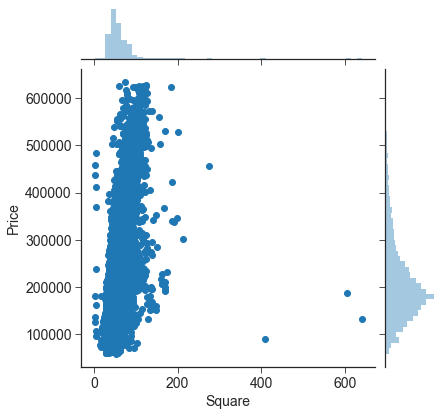

In [46]:
# Разброс площадей на графике
sns.jointplot(train_df['Square'], train_df['Price'], kind='scatter', height=6);

<AxesSubplot:xlabel='Square'>

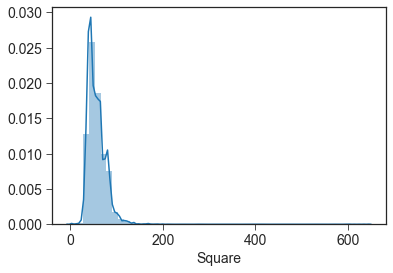

In [47]:
sns.distplot(train_df['Square'])

In [48]:
# Площади квартир меньше 20 кв.м. и больше 300 
train_df.loc[(train_df['Square'] < 20) | (train_df['Square'] > 300)] 


,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
1748,88,2.0,5.497061,67.628717,1.0,24,22.0,1977,0.127376,1,1,43,8429,3,750.0,3,9,1,412511.088764
11526,27,1.0,4.633498,1.969969,1.0,18,1.0,1977,0.011654,1,1,4,915,0,750.0,0,0,1,107604.269441
10202,6,1.0,2.596351,4.604943,1.0,3,25.0,2014,0.243205,1,1,5,1564,0,540.0,0,0,1,137597.601458
13685,0,1.0,17.498542,13.446544,0.0,7,5.0,1961,0.319809,1,1,25,4756,16,2857.0,5,8,1,88871.750230
15127,150,1.0,17.046188,20.036232,8.0,7,12.0,1982,0.300323,1,1,52,10311,6,1340.0,1,9,1,74222.110465
10527,27,1.0,4.380726,40.805837,1.0,10,17.0,2013,0.211401,1,1,9,1892,0,750.0,0,1,1,97560.720383
9487,5,1.0,5.129222,5.549458,1.0,1,1.0,1977,0.150818,1,1,16,3433,4,2643.0,4,5,1,369472.403061
523,101,1.0,18.509177,15.170851,3.0,5,5.0,1970,0.225825,0,1,41,6558,7,1548.0,3,2,1,115845.861527
28,9,2.0,604.705972,31.798338,1.0,17,18.0,1977,0.161532,1,1,25,5648,1,30.0,2,4,1,187717.242538


In [49]:
# Медианные площади квартир, сгруппированных по количеству комнат
train_df.groupby('Rooms')['Square'].median()

Rooms
1.0     40.406590
2.0     55.850302
3.0     77.421742
4.0     98.668054
5.0    118.363960
Name: Square, dtype: float64

In [50]:
# Заменим выбросы по Square на медианные значения площадей квартир, сгруппированных по количеству комнат:
train_df.loc[(train_df['Square'] < 20) & (train_df['Rooms'] == 1), 'Square'] = 40.409907
train_df.loc[(train_df['Square'] < 20) & (train_df['Rooms'] == 2), 'Square'] = 55.850302
train_df.loc[(train_df['Square'] < 20) & (train_df['Rooms'] == 3), 'Square'] = 77.421742
train_df.loc[(train_df['Square'] < 20) & (train_df['Rooms'] == 6), 'Square'] = 118.363960
train_df.loc[(train_df['Square'] > 300) & (train_df['Rooms'] == 1), 'Square'] =  40.409907
train_df.loc[(train_df['Square'] > 300) & (train_df['Rooms'] == 2), 'Square'] = 55.850302

In [51]:
# Проверяем отсутствие квартир меньше 20 кв.м. и больше 300 
train_df.loc[(train_df['Square'] < 20) | (train_df['Square'] > 300)] 

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,


In [52]:
# Аналогично по тестовому датасету
# Площади квартир меньше 20 кв.м. и больше 300 
test_df.loc[(test_df['Square'] < 20) | (test_df['Square'] > 300)] 

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,1,1,30,7538,87,4702.0,5,5,1
9011,53,1.0,1.378543,1.353573,1.0,1,1.0,1977,0.049637,1,1,34,7759,0,229.0,1,3,1
3458,101,1.0,19.043894,13.941145,3.0,4,5.0,1970,0.225825,0,1,41,6558,7,1548.0,3,2,1
16401,30,1.0,2.645046,4.338755,1.0,2,1.0,1977,0.000078,1,1,22,6398,141,1046.0,3,23,1
2138,27,1.0,5.647458,1.501582,1.0,1,1.0,1977,0.017647,1,1,2,469,0,900.0,0,0,1
10120,6,1.0,5.100672,3.861780,1.0,3,1.0,1977,0.243205,1,1,5,1564,0,540.0,0,0,1
3969,101,1.0,18.149267,9.698766,3.0,4,5.0,1967,0.225825,0,1,41,6558,7,1548.0,3,2,1
9884,29,1.0,17.273699,16.452172,2.0,3,5.0,1962,0.069660,1,1,31,6119,4,900.0,1,2,1
7533,66,1.0,16.319015,11.118981,1.0,4,5.0,1965,0.111627,1,1,50,12238,8,1970.0,2,3,1


In [53]:
# Заменим выбросы по Square на медианные значения площадей квартир, сгруппированных по количеству комнат:
test_df.loc[(test_df['Square'] < 20) & (test_df['Rooms'] == 1), 'Square'] = 40.409907
test_df.loc[(test_df['Square'] < 20) & (test_df['Rooms'] == 2), 'Square'] = 55.850302

In [54]:
# Проверяем отсутствие квартир меньше 20 кв.м. и больше 300 
test_df.loc[(test_df['Square'] < 20) | (test_df['Square'] > 300)] 

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,


##### KitchenSquare

In [55]:
# Медианные площади кухонь в квартирах, сгруппированных по количеству комнат
train_df.groupby('Rooms')['KitchenSquare'].median()

Rooms
1.0    6.0
2.0    6.0
3.0    7.0
4.0    9.0
5.0    8.5
Name: KitchenSquare, dtype: float64

In [56]:
# Площади кухонь больше 20 кв.м. и больше общей площади квартир 
train_df.loc[(train_df['KitchenSquare'] > 20) 
             & (train_df['KitchenSquare'] > train_df['Square'])] 
# Все эти квартиры 1 комнатные

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14656,62,1.0,47.100719,46.447960,2014.0,4,1.0,2014,0.072158,1,1,2,629,1,2300.0,0,0,0,108337.484207
13703,42,1.0,38.071692,19.723548,73.0,9,10.0,2006,0.158249,1,1,21,5731,0,750.0,1,0,1,160488.033165
6569,27,1.0,38.220258,18.716856,84.0,4,17.0,2018,0.011654,1,1,4,915,0,750.0,0,0,1,99079.960518
14679,81,1.0,32.276663,19.278394,1970.0,6,1.0,1977,0.006076,1,1,30,5285,0,645.0,6,6,1,105539.556275


In [57]:
# Аналогично в тестовом датасете
# Площади кухонь больше 20 кв.м. и больше общей площади квартир 
test_df.loc[(test_df['KitchenSquare'] > 20) 
            & (test_df['KitchenSquare'] > test_df['Square']) 
          ] 
# Все эти квартиры 1 и 2 комнатные

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
14594,11,2.0,42.795304,24.223770,620.0,11,14.0,1972,0.038693,1,1,28,6533,1,1015.0,2,5,1
10662,29,1.0,25.956829,17.251768,33.0,5,5.0,1973,0.069660,1,1,31,6119,4,900.0,1,2,1
3194,29,2.0,43.926987,31.028707,44.0,6,5.0,1964,0.086885,1,1,10,2277,2,1547.0,0,0,1
12640,6,2.0,54.629142,31.486308,97.0,4,17.0,2015,0.243205,1,1,5,1564,0,540.0,0,0,1


In [58]:
# Заменим на медианную площадь 1 и 2-х комнатных квартир
train_df.loc[(train_df['KitchenSquare'] > 20) 
             & (train_df['KitchenSquare'] > train_df['Square']), 'KitchenSquare'] = 6
test_df.loc[(test_df['KitchenSquare'] > 20) 
            & (test_df['KitchenSquare'] > test_df['Square']), 'KitchenSquare']  = 6

In [59]:
# Проверка замены
test_df.loc[(test_df['KitchenSquare'] > 20) 
            & (test_df['KitchenSquare'] > test_df['Square'])] 

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,


##### LifeSquare

In [60]:
# Медианные LifeSquare в квартирах, сгруппированных по количеству комнат
train_df.groupby('Rooms')['LifeSquare'].median()

Rooms
1.0    22.923518
2.0    33.745816
3.0    45.825691
4.0    64.267635
5.0    80.458910
Name: LifeSquare, dtype: float64

In [61]:
# LifeSquare больше общей площади квартир 
train_df.loc[(train_df['LifeSquare'] > train_df['Square'])] 

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
8054,23,1.0,42.530043,43.967759,1.0,3,9.0,2014,0.034656,1,1,0,168,0,0.0,0,0,1,95338.198549
11703,23,1.0,41.118766,43.896847,1.0,4,17.0,1977,0.075779,1,1,6,1437,3,0.0,0,2,1,103510.223601
10521,38,3.0,104.211396,106.340403,0.0,20,0.0,2017,0.060753,1,1,15,2787,2,520.0,0,7,1,435462.048070
2301,1,2.0,61.400054,65.224603,0.0,17,22.0,2016,0.007122,1,1,1,264,0,240.0,0,1,1,199215.452229
16334,1,1.0,42.414176,42.457422,1.0,14,17.0,1977,0.007122,1,1,1,264,0,240.0,0,1,1,156476.614348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14001,73,1.0,44.098768,44.267551,1.0,7,24.0,2014,0.042032,1,1,37,6856,84,1940.0,2,5,1,381937.404161
3171,62,1.0,35.873961,40.422451,0.0,25,0.0,1977,0.072158,1,1,2,629,1,2300.0,0,0,0,134379.130962
16568,27,4.0,200.334539,201.627361,25.0,1,2.0,2013,0.041116,1,1,53,14892,4,750.0,1,4,1,528560.506016


In [62]:
# Аналогично в тестовом датасете
# LifeSquare больше общей площади квартир 
test_df.loc[(test_df['LifeSquare'] > test_df['Square'])] 

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
5214,27,1.0,37.555197,40.857569,1.0,5,1.0,1977,0.211401,1,1,9,1892,0,900.0,0,1,1
11160,58,1.0,48.610661,48.752502,1.0,4,3.0,1977,0.437885,1,1,23,5735,3,1084.0,0,5,1
6624,27,1.0,42.413793,42.434887,10.0,12,17.0,2017,0.011654,1,1,4,915,0,900.0,0,0,1
11513,1,1.0,37.484057,40.593036,0.0,4,17.0,1977,0.007122,1,1,1,264,0,900.0,0,1,1
12309,45,1.0,42.899569,44.927374,0.0,25,0.0,1977,0.195781,1,1,23,5212,6,900.0,3,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7639,27,1.0,38.756507,40.857569,1.0,7,1.0,1977,0.211401,1,1,9,1892,0,900.0,0,1,1
5820,94,1.0,33.680382,34.198977,1.0,10,9.0,1972,0.127376,1,1,43,8429,3,900.0,3,9,1
4821,74,2.0,82.542507,82.585069,0.0,4,17.0,2015,0.309479,1,1,35,7715,4,990.0,0,6,1


In [63]:
# Заменим LifeSquare, которые больше общей площади квартир, на медианные:
train_df.loc[(train_df['LifeSquare'] > train_df['Square']) & (train_df['Rooms'] == 1), 'LifeSquare'] = 22.923720
train_df.loc[(train_df['LifeSquare'] > train_df['Square']) & (train_df['Rooms'] == 2), 'LifeSquare'] = 33.745816
train_df.loc[(train_df['LifeSquare'] > train_df['Square']) & (train_df['Rooms'] == 3), 'LifeSquare'] = 45.825691
train_df.loc[(train_df['LifeSquare'] > train_df['Square']) & (train_df['Rooms'] == 4), 'LifeSquare'] = 64.267635
train_df.loc[(train_df['LifeSquare'] > train_df['Square']) & (train_df['Rooms'] == 5), 'LifeSquare'] = 80.458910

test_df.loc[(test_df['LifeSquare'] > test_df['Square']) & (test_df['Rooms'] == 1), 'LifeSquare'] = 22.923720
test_df.loc[(test_df['LifeSquare'] > test_df['Square']) & (test_df['Rooms'] == 2), 'LifeSquare'] = 33.745816
test_df.loc[(test_df['LifeSquare'] > test_df['Square']) & (test_df['Rooms'] == 3), 'LifeSquare'] = 45.825691
test_df.loc[(test_df['LifeSquare'] > test_df['Square']) & (test_df['Rooms'] == 4), 'LifeSquare'] = 64.267635
test_df.loc[(test_df['LifeSquare'] > test_df['Square']) & (test_df['Rooms'] == 5), 'LifeSquare'] = 80.458910

#### Выбросы по этажам

In [64]:
# Рассмотрим статистику по этажам
train_df[['Floor', 'HouseFloor']].describe()

,Floor,HouseFloor
count,10000.000000,10000.000000
mean,8.526700,12.609400
std,5.241148,6.775974
min,1.000000,0.000000
25%,4.000000,9.000000
50%,7.000000,13.000000
75%,12.000000,17.000000
max,42.000000,117.000000


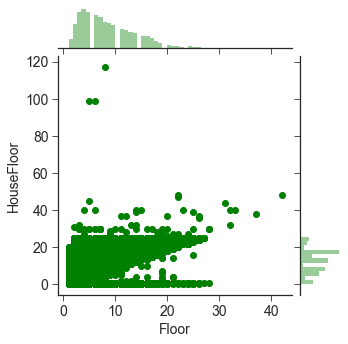

In [65]:
# Построим график связи этажности дома и этажа квартиры
sns.jointplot(train_df['Floor'], train_df['HouseFloor'], kind='scatter', height=5, color='g');

##### HouseFloor

In [66]:
# Дома с нулем этажей
train_df.loc[(train_df['HouseFloor'] == 0)] 

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
11993,74,2.0,80.312926,46.213732,0.0,14,0.0,1977,0.075779,1,1,6,1437,3,750.0,0,2,1,221244.156664
6641,54,3.0,118.907612,42.815291,0.0,2,0.0,1977,0.006076,1,1,30,5285,0,645.0,6,6,1,571069.052600
4378,27,3.0,106.958871,0.641822,0.0,17,0.0,2018,0.072158,1,1,2,629,1,750.0,0,0,0,337299.867936
9371,23,2.0,60.503248,43.896847,0.0,16,0.0,1977,0.034656,1,1,0,168,0,0.0,0,0,1,229778.057902
10521,38,3.0,104.211396,45.825691,0.0,20,0.0,2017,0.060753,1,1,15,2787,2,520.0,0,7,1,435462.048070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12302,30,1.0,46.072913,22.923720,0.0,4,0.0,1977,0.000078,1,1,22,6398,141,1046.0,3,23,1,161403.094034
9384,59,3.0,98.607328,37.264583,0.0,14,0.0,1977,0.019509,1,1,37,7687,11,176.0,5,5,1,492700.257473
11441,62,2.0,71.985335,33.745816,0.0,5,0.0,1977,0.072158,1,1,2,629,1,2300.0,0,0,0,158841.624543


In [67]:
# Замена нулевой этажности на моду
train_df.loc[(train_df['HouseFloor'] == 0), 'HouseFloor'] = train_df['HouseFloor'].mode()[0]

In [68]:
# Аналогично для теста
# Замена нулевой этажности на моду
test_df.loc[(test_df['HouseFloor'] == 0), 'HouseFloor'] = train_df['HouseFloor'].mode()[0]

In [69]:
# Дома с чрезмерной этажностью
train_df.loc[(train_df['HouseFloor'] > 60)]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
10806,5,1.0,51.944587,48.709601,1.0,6,99.0,1977,0.150818,1,1,16,3433,4,2643.0,4,5,1,296127.115515
9300,74,2.0,71.747869,33.745816,9.0,5,99.0,1977,0.075779,1,1,6,1437,3,750.0,0,2,1,243329.912579
78,30,2.0,65.773749,33.745816,1.0,8,117.0,1977,0.000078,1,1,22,6398,141,1046.0,3,23,1,207248.370520


In [70]:
# Замена чрезмерной этажности на моду (судя по графику - свыше 60 этажей)
train_df.loc[(train_df['HouseFloor'] > 60), 'HouseFloor'] = train_df['HouseFloor'].mode()[0]

In [71]:
# Аналогично для теста
# Замена чрезмерной этажности на моду
test_df.loc[(test_df['HouseFloor'] > 60), 'HouseFloor'] = train_df['HouseFloor'].mode()[0]

##### Floor

In [72]:
# Этаж квартиры больше этажности дома
floor_train = train_df.loc[train_df['Floor'] > train_df['HouseFloor']]
floor_train

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
10953,27,1.0,53.769097,52.408027,1.0,5,4.0,1977,0.072158,1,1,2,629,1,750.0,0,0,0,140647.565937
2119,27,2.0,49.360648,31.993964,5.0,6,5.0,1983,0.051815,1,1,5,1227,0,750.0,0,0,1,117000.381287
11935,27,2.0,64.711835,37.635393,1.0,15,1.0,1977,0.211401,1,1,9,1892,0,750.0,0,1,1,127200.026511
6486,200,3.0,85.280389,58.447967,9.0,6,5.0,1960,0.000000,1,1,33,7425,1,750.0,2,5,1,402871.916317
10521,38,3.0,104.211396,45.825691,0.0,20,17.0,2017,0.060753,1,1,15,2787,2,520.0,0,7,1,435462.048070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2237,52,3.0,64.074977,47.633428,6.0,11,9.0,1983,0.371149,1,1,34,7065,1,750.0,2,5,1,226434.880156
16159,27,1.0,38.968338,37.635393,1.0,10,1.0,1977,0.211401,1,1,9,1892,0,750.0,0,1,1,95529.569405
4145,96,3.0,90.055233,47.860231,11.0,26,24.0,2005,0.041116,1,1,53,14892,4,750.0,1,4,1,441108.911237


In [73]:
# Этаж квартиры больше этажности дома
floor_test = test_df.loc[test_df['Floor'] > test_df['HouseFloor']]
floor_test

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
15856,74,2.0,69.263183,47.919762,1.0,6,1.0,1977,0.075779,1,1,6,1437,3,900.0,0,2,1
15975,61,3.0,64.543658,42.651541,7.0,10,9.0,1981,0.300323,1,1,52,10311,6,900.0,1,9,1
5214,27,1.0,37.555197,22.923720,1.0,5,1.0,1977,0.211401,1,1,9,1892,0,900.0,0,1,1
11160,58,1.0,48.610661,22.923720,1.0,4,3.0,1977,0.437885,1,1,23,5735,3,1084.0,0,5,1
9348,205,1.0,37.480811,16.851795,8.0,6,5.0,1933,0.169091,1,1,19,3856,10,900.0,2,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15181,27,4.0,104.664209,66.903563,1.0,4,1.0,2016,0.017647,1,1,2,469,0,900.0,0,0,1
16064,30,1.0,38.376234,37.003311,1.0,2,1.0,1977,0.000078,1,1,22,6398,141,1046.0,3,23,1
2591,39,2.0,44.203592,30.191691,6.0,10,9.0,1972,0.428826,1,1,25,5011,8,730.0,0,2,1


In [74]:
# Среднее отношение этажа квартиры к этажности дома
floor_ratio = (train_df.loc[(train_df['Floor'] < train_df['HouseFloor']), 'Floor'] / train_df.loc[(train_df['Floor'] < train_df['HouseFloor']), 'HouseFloor']).mean()
floor_ratio

0.5364276390870701

In [75]:
# Заменим этажность квартир, которые превышают этажность дома, 
# путем умножения этажности дома на вычисленный коэффициент
train_df.loc[floor_train.index, 'Floor'] = train_df.loc[floor_train.index, 'HouseFloor'] * floor_ratio

In [76]:
# Аналогично по тестовому датасету
# Заменим этажность квартир, которые превышают этажность дома, 
# путем умножения этажности дома на вычисленный коэффициент
test_df.loc[floor_test.index, 'Floor'] = test_df.loc[floor_test.index, 'HouseFloor'] * floor_ratio

In [77]:
# Проверка замены
# Этаж квартиры больше этажности дома
floor_train = train_df.loc[train_df['Floor'] > train_df['HouseFloor']]
floor_train

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,


In [78]:
# Приведем значения к целому
round(train_df['Floor'])
train_df['HouseFloor'].astype(int)
test_df['Floor'].astype(int)
test_df['HouseFloor'].astype(int)
train_df['Floor']

Id
14038     7.000000
15053     7.000000
4765      8.000000
5809      8.000000
10783    11.000000
           ...    
77        2.682138
6159     13.000000
5123     12.000000
5400      1.000000
6306      7.000000
Name: Floor, Length: 10000, dtype: float64

#### Выбросы по году постройки дома

In [79]:
# Рассмотрим годы, выходящие за границы
train_df.loc[(train_df['HouseYear'] > 2020) | (train_df['HouseYear'] < 1910)]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
10814,109,1.0,37.265070,20.239714,9.0,9.0,12.0,20052011,0.136330,1,1,30,6141,10,262.0,3,6,1,254084.534396
11607,147,2.0,44.791836,28.360393,5.0,4.0,9.0,4968,0.319809,1,1,25,4756,16,2857.0,5,8,1,243028.603096


In [80]:
test_df.loc[(test_df['HouseYear'] > 2020) | (test_df['HouseYear'] < 1910)]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
5480,190,1.0,40.409907,15.948246,12.0,2.0,5.0,1909,0.000000,1,1,30,7538,87,4702.0,5,5,1
12316,183,5.0,157.976101,101.040485,12.0,7.0,8.0,1908,0.246624,1,1,14,2940,45,900.0,3,6,1


In [81]:
# Заменим склеенное значение года на среднее 
train_df.loc[train_df['HouseYear'] == 20052011, 'HouseYear'] = int((2005 + 2011) / 2)

In [82]:
# Заменим значение 4968 на 1968 
train_df.loc[train_df['HouseYear'] == 4968, 'HouseYear'] = 1968

In [83]:
# Проверим замены
train_df.loc[(train_df['HouseYear'] > 2020) | (train_df['HouseYear'] < 1910)]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,


### Построение новых признаков

In [84]:
# price_per_square - стоимость квадратного метра
train_df['price_per_square'] = train_df['Price'] / train_df['Square']
train_df['price_per_square'].describe()

count    10000.000000
mean      3889.948578
std       1254.755206
min        752.588644
25%       2914.807447
50%       3904.251132
75%       4689.587074
max      11959.529827
Name: price_per_square, dtype: float64

In [85]:
# price_per_square_by_distr - стоимость квадратного метра в зависимости от района
price_per_square_by_distr = train_df.groupby(['DistrictId'], as_index=False)\
                        .agg({'price_per_square':'median'})\
                        .rename(columns={'price_per_square':'price_per_square_by_distr'})
price_per_square_by_distr

,DistrictId,price_per_square_by_distr
0,0,3721.970145
1,1,3251.202203
2,10,4458.893222
3,100,4933.389994
4,101,4185.964052
...,...,...
200,95,5496.385874
201,96,4025.341982
202,97,4942.568587
203,98,4444.979920


In [86]:
# Добавим новый признак к датасетам 
train_df = train_df.merge(price_per_square_by_distr, on=['DistrictId'], how='left').set_index(train_df.index)
test_df = test_df.merge(price_per_square_by_distr, on=['DistrictId'], how='left').set_index(test_df.index)

In [87]:
# В тестовом датасете по созданному признаку имеются Null значения 
test_df['price_per_square_by_distr'].isna().sum()

8

In [88]:
# Найдем эти 8 Null значения
test_df.loc[test_df['price_per_square_by_distr'].isnull()]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,price_per_square_by_distr
Id,,,,,,,,,,,,,,,,,,,
15748,212,2.0,75.655182,36.877626,15.0,2.000000,7.0,1929,0.000000e+00,1,1,8,1423,37,562.0,1,8,1,NaN
14939,210,2.0,54.953826,31.223917,6.0,3.000000,10.0,1956,8.194346e-02,1,1,20,2738,20,900.0,1,4,1,NaN
16217,206,4.0,76.428426,50.344903,11.0,3.218566,6.0,1912,4.203159e-02,1,1,37,6856,84,1940.0,2,5,1,NaN
9155,204,3.0,88.559337,62.854221,8.0,3.754993,7.0,1918,3.731645e-02,1,1,32,6748,93,562.0,4,10,1,NaN
8845,203,2.0,50.417709,27.587971,7.0,2.145711,4.0,1977,1.501689e-02,1,1,17,3079,59,2890.0,0,8,1,NaN
15655,211,2.0,46.501558,32.276987,5.0,5.000000,5.0,1965,1.800000e-09,1,1,16,3681,73,1815.0,2,5,1,NaN
13382,206,2.0,46.047289,27.384090,6.0,5.000000,7.0,1930,7.815280e-05,1,1,22,6398,141,1046.0,3,23,1,NaN
14024,198,2.0,47.477281,31.069466,5.0,2.000000,5.0,1970,6.076152e-03,1,1,30,5285,0,645.0,6,6,1,NaN


In [89]:
# Заменим эти 8 Null значений на моду
test_df.loc[test_df['price_per_square_by_distr'].isnull(), 'price_per_square_by_distr'] = train_df['price_per_square_by_distr'].mode()[0]

In [90]:
# Проверим на отсутствие Null
test_df['price_per_square_by_distr'].isna().sum()

0

### Взаимосвязь параметров

In [91]:
# Взаимосвязь параметров с ценой:
train_df.corr()['Price'].sort_values()

Ecology_1                   -0.058381
Ecology_3                   -0.052585
Ecology_2                    0.022379
HouseYear                    0.036628
Shops_2                      0.070388
Social_3                     0.074878
HouseFloor                   0.086219
Floor                        0.107000
Shops_1                      0.180876
Healthcare_1                 0.200040
Social_2                     0.239226
Helthcare_2                  0.253090
KitchenSquare                0.255675
Social_1                     0.263286
LifeSquare                   0.399557
price_per_square_by_distr    0.528382
Rooms                        0.571653
Square                       0.580705
price_per_square             0.634913
Price                        1.000000
Name: Price, dtype: float64

In [92]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   DistrictId                 10000 non-null  object 
 1   Rooms                      10000 non-null  float64
 2   Square                     10000 non-null  float64
 3   LifeSquare                 10000 non-null  float64
 4   KitchenSquare              10000 non-null  float64
 5   Floor                      10000 non-null  float64
 6   HouseFloor                 10000 non-null  float64
 7   HouseYear                  10000 non-null  int64  
 8   Ecology_1                  10000 non-null  float64
 9   Ecology_2                  10000 non-null  int64  
 10  Ecology_3                  10000 non-null  int64  
 11  Social_1                   10000 non-null  int64  
 12  Social_2                   10000 non-null  int64  
 13  Social_3                   10000 non-null  

### Анализ целевой переменной

In [93]:
train_df['Price'].describe()

count     10000.000000
mean     214138.857399
std       92872.293865
min       59174.778028
25%      153872.633942
50%      192269.644879
75%      249135.462171
max      633233.466570
Name: Price, dtype: float64

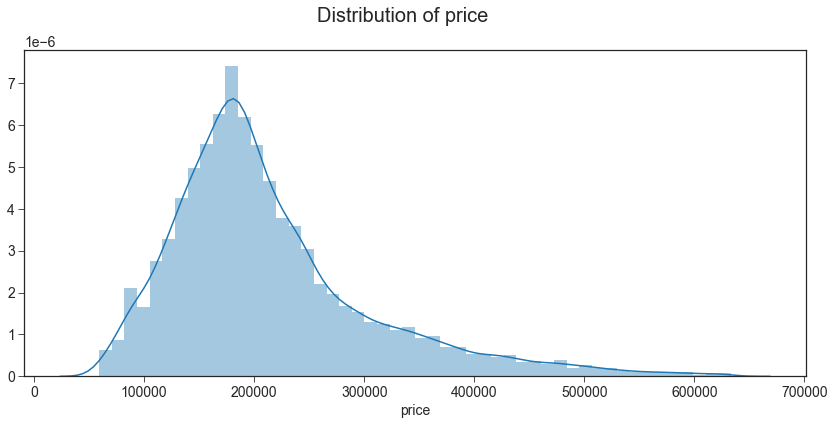

In [94]:
plt.figure(figsize = (14, 6))
# строим график плотности распределения
sns.distplot(train_df['Price'])
plt.xlabel('price')
plt.suptitle('Distribution of price', size=20);

In [95]:
# Рассчитаем среднюю, медиану для price
target_mean = round(train_df['Price'].mean(), 2)
target_median = train_df['Price'].median()

target_mean, target_median

(214138.86, 192269.64487934904)

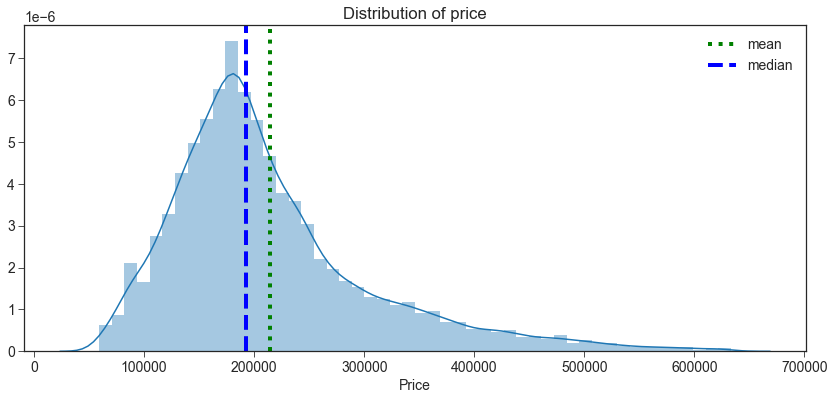

In [96]:
# Нанесем среднюю, медиану и моду на график
plt.figure(figsize = (14, 6))
sns.distplot(train_df['Price'])
plt.title('Distribution of price')
plt.axvline(target_mean, color='g', label='mean', linestyle=':', linewidth=4)
plt.axvline(target_median, color='b', label='median', linestyle='--', linewidth=4)

plt.legend();

### Анализ признаков

In [97]:
feature_num_names = train_df.drop('Price', axis=1).select_dtypes(include='float64').columns.tolist()
feature_num_names

['Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'Ecology_1',
 'Healthcare_1',
 'price_per_square',
 'price_per_square_by_distr']

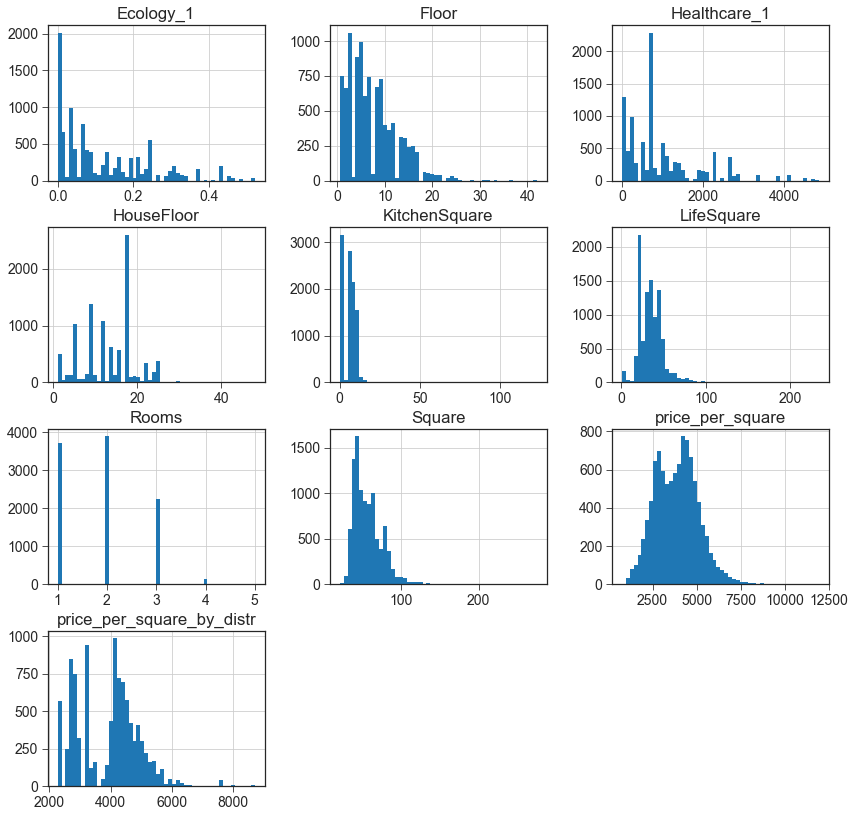

In [98]:
train_df[feature_num_names].hist(figsize=(14,14), bins=50, grid=True);

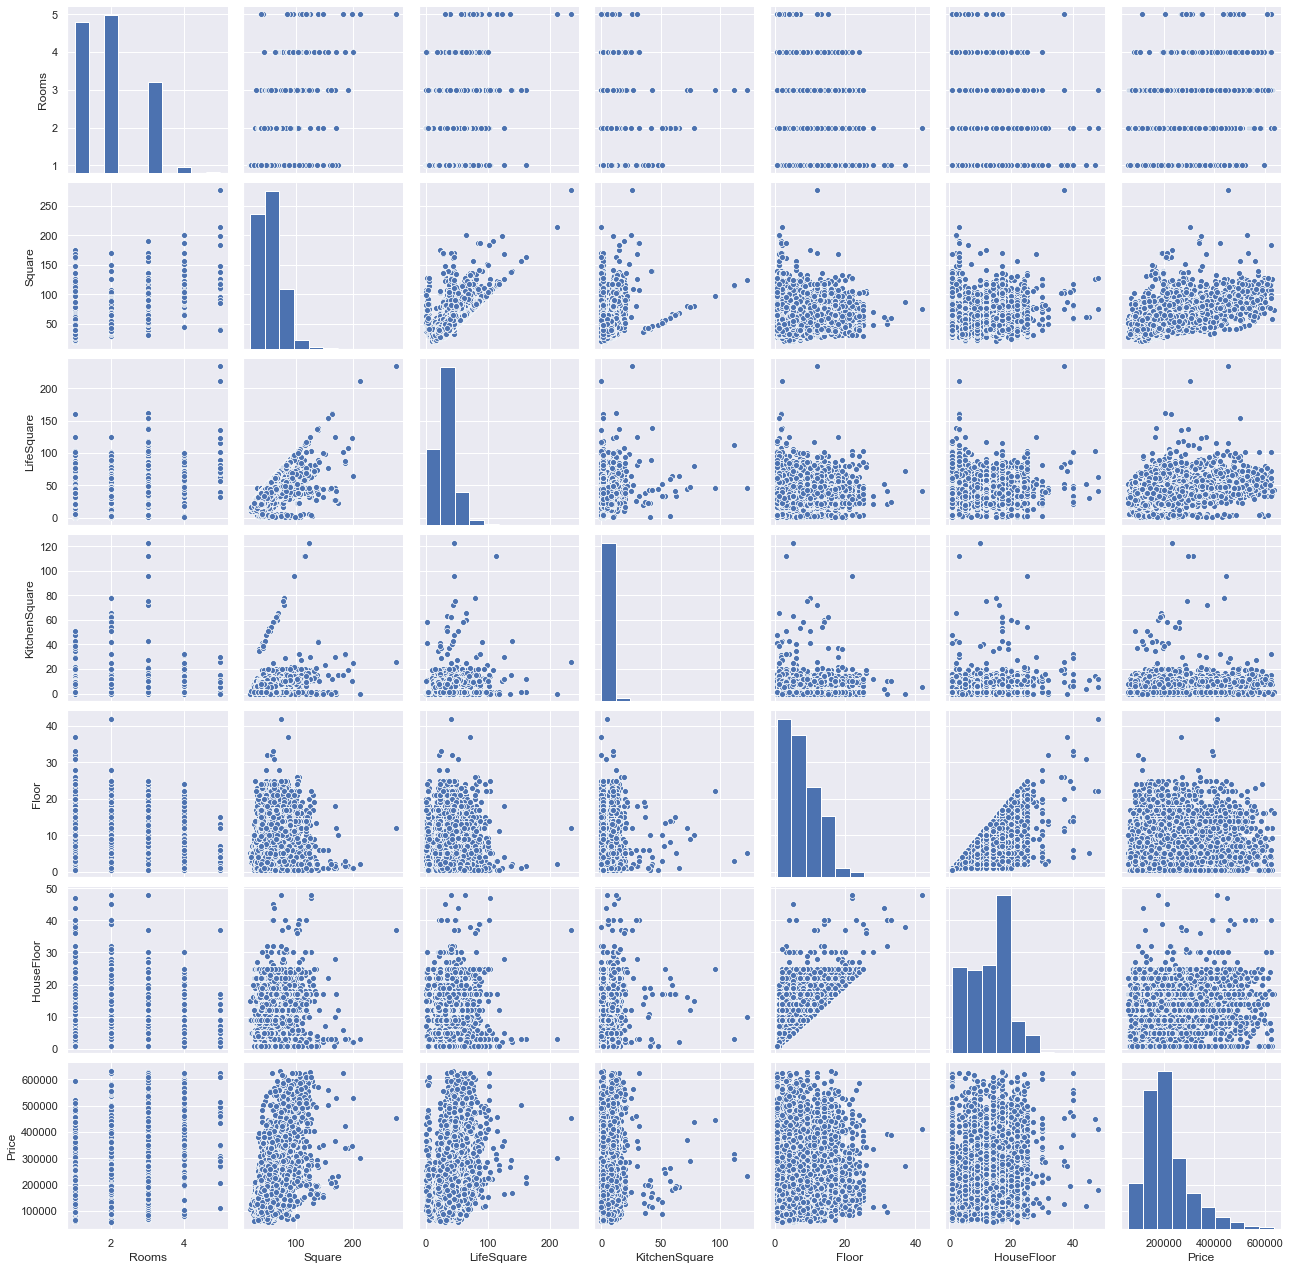

In [99]:
# Взаимосвязи между количественными признаками
sns.set()
sns.pairplot(train_df[feature_num_names[:6] + ['Price']]);

In [100]:
# Бинарные признаки
feature_bin_names = train_df.select_dtypes(include='int64').columns.tolist()
feature_bin_names

['HouseYear',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2']

### МАтрица корреляций

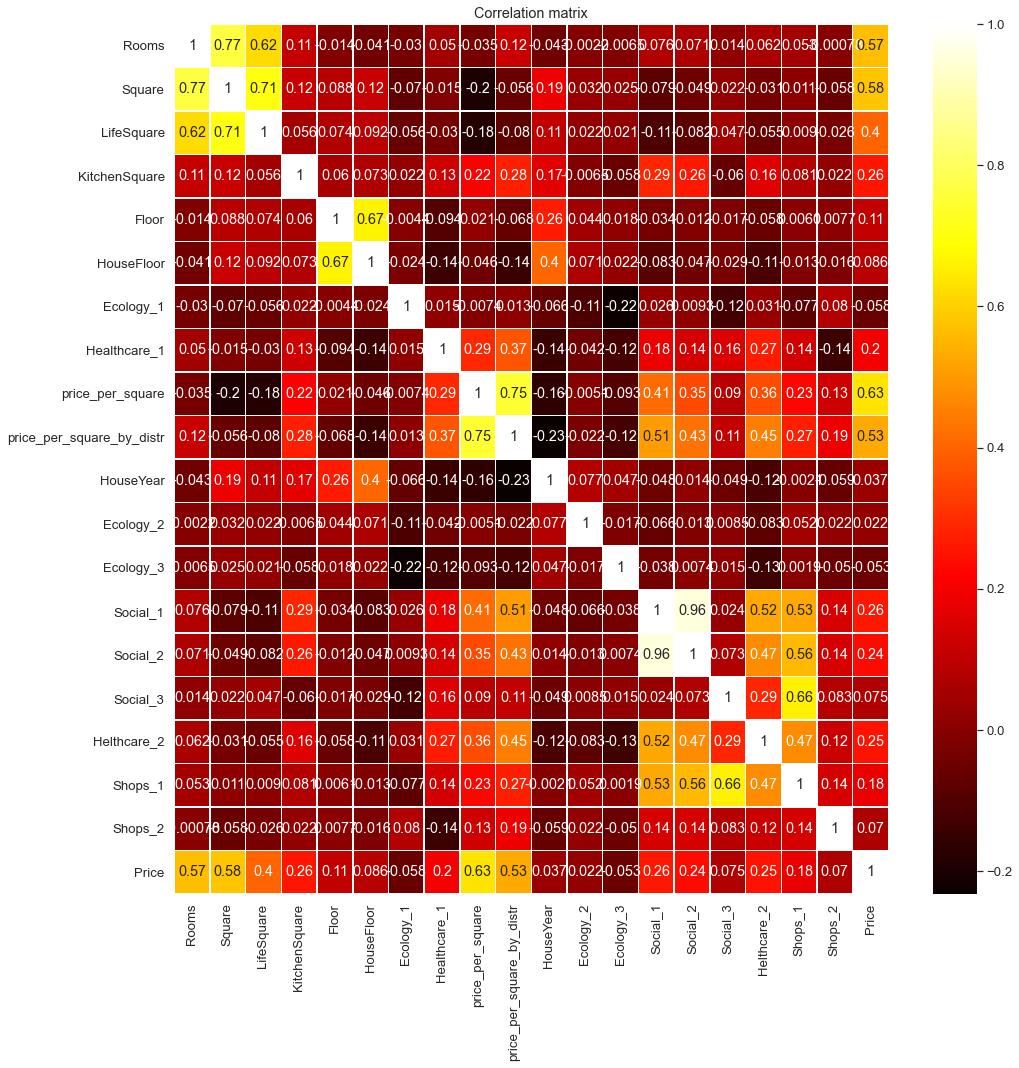

In [101]:
plt.figure(figsize = (16,16))

sns.set(font_scale=1.2)
sns.heatmap(train_df[feature_num_names + feature_bin_names + ['Price']].corr(), 
            annot=True, linewidths=.5, cmap='hot')

plt.title('Correlation matrix');

### Отбор признаков

In [317]:
train_df.to_csv('train_prepared.csv')
test_df.to_csv('test_prepared.csv')

In [102]:
feature_names = train_df.columns
feature_names.tolist()

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'price_per_square',
 'price_per_square_by_distr']

In [103]:
feature_names = [
                'DistrictId',            
                'Rooms',
                'Square',
                'KitchenSquare',
                'LifeSquare',
                'Floor',
                'HouseFloor',
                'HouseYear',
                'Ecology_1',
                'Ecology_2',
                'Ecology_3',
                'Social_1',
                'Social_2',
                'Social_3',
                'Healthcare_1',
                'Helthcare_2',
                'Shops_1',
                'Shops_2',
#                'Price',
                'price_per_square_by_distr',
#                'price_per_square'
]

In [104]:
# Отбираем массивы фич и ответов по ценам
X = train_df[feature_names]
y = train_df['Price']

X_test = test_df[feature_names]

In [105]:
X.head()

,DistrictId,Rooms,Square,KitchenSquare,LifeSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,price_per_square_by_distr
Id,,,,,,,,,,,,,,,,,,,
14038,35,2.0,47.981561,6.0,29.442751,7.0,9.0,1969,0.089040,1,1,33,7976,5,750.0,0,11,1,4358.274853
15053,41,3.0,65.683640,8.0,40.049543,7.0,9.0,1978,0.000070,1,1,46,10309,1,240.0,1,16,1,4437.304072
4765,53,2.0,44.947953,0.0,29.197612,8.0,12.0,1968,0.049637,1,1,34,7759,0,229.0,1,3,1,4845.919064
5809,58,2.0,53.352981,9.0,52.731512,8.0,17.0,1977,0.437885,1,1,23,5735,3,1084.0,0,5,1,2949.975415
10783,99,1.0,39.649192,7.0,23.776169,11.0,12.0,1976,0.012339,1,1,35,5776,1,2078.0,2,4,1,3992.031265


### Построение моделей

##### RandomForestRegressor

In [106]:
forest_model = RandomForestRegressor(max_depth=19, max_features=6, n_estimators=100,
random_state=42)

In [107]:
# Производим перекрестную проверку
scores_f = cross_val_score(forest_model, X, y, cv=KFold(n_splits=5, shuffle=True, random_state=42), scoring='r2')
print('R2 для случайного леса = ', round(scores_f.mean(), 4))

R2 для случайного леса =  0.7548


In [108]:
# Оцениваем важность признаков
forest_model.fit(X, y)
importances = forest_model.feature_importances_
feat_importances = pd.Series(importances, index=feature_names)
feat_importances.sort_values(ascending=True, inplace=True)

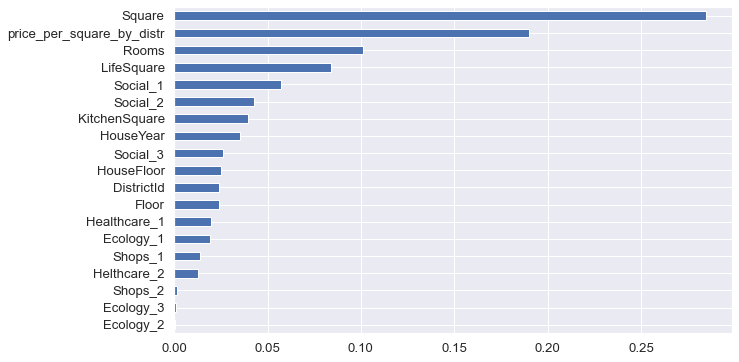

In [109]:
# СТроим график значимости признаков
feat_importances.plot(kind='barh', figsize=(10, 6));

##### Linear Regression

In [110]:
# Обучаем модель на тренировочных данных
lr_model = LinearRegression()
lr_model.fit(X, y)

LinearRegression()

In [111]:
# Производим перекрестную проверку
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores_lr = cross_val_score(lr_model, X, y, cv=cv, scoring='r2', n_jobs=-1)
scores_lr

array([0.64159658, 0.67270069, 0.66747212, 0.67560298, 0.69256338])

In [112]:
print('R2 для линейной регрессии = ', round(scores_lr.mean(), 4))

R2 для линейной регрессии =  0.67


результат - не очень

##### Gradient Boosting

In [113]:
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X, y)

GradientBoostingRegressor(random_state=42)

In [114]:
# Производим перекрестную проверку
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores_gb = cross_val_score(gb_model, X, y, cv=cv, scoring='r2', n_jobs=-1)
scores_gb

array([0.72259759, 0.746615  , 0.73913293, 0.74707795, 0.77392208])

In [115]:
print('R2 для градиентного бустинга = ', round(scores_gb.mean(), 4))

R2 для градиентного бустинга =  0.7459


#### Настройка наилучшей модели

In [116]:
# Наилучшая модель - RandomForest
params = {'n_estimators':[300], 
          'max_depth':[18, 19, 20], 'max_features': [5,6,7]}

gs = GridSearchCV(forest_model, params, scoring='r2', 
                  cv=KFold(n_splits=5, shuffle=True, random_state=42), n_jobs=-1)
gs.fit(X, y)

print(gs.best_params_)
print('R2 на train: {:.5f}'.format(gs.best_score_)) 

{'max_depth': 18, 'max_features': 7, 'n_estimators': 300}
R2 на train: 0.75839


### Обучение и оценка модели

In [117]:
forest_best = gs.best_estimator_

y_pred = forest_best.predict(X_test)

In [118]:
# Создадим датафрейм согласно условиям задания - два поля: Id, Price
preds = pd.DataFrame()
preds['Id'] = X_test.index
preds['Price'] = y_pred
preds.head()

,Id,Price
0,725,157547.294309
1,15856,221954.870357
2,5480,311146.021292
3,15664,308816.524640
4,14275,150234.218010


In [123]:
preds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      5000 non-null   int64  
 1   Price   5000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 78.2 KB


In [124]:
# Передадим данные в файл CSV
preds.to_csv('Kuatov_predictions.csv', index=False)